In [8]:
import numpy as np
import trimesh as tri
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import listdir

from utils import lddmm_utils, mesh_processing

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Random resampling unit sphere

In [9]:
mesh = tri.creation.uv_sphere()
mesh

<trimesh.Trimesh(vertices.shape=(2016, 3), faces.shape=(3780, 3))>

In [10]:
sampled = tri.sample.sample_surface_even(mesh, 16*16)
param = tri.convex.convex_hull(sampled[0])

In [11]:
sampled = tri.sample.sample_surface(mesh, 16*16)
reparam = tri.convex.convex_hull(sampled[0])

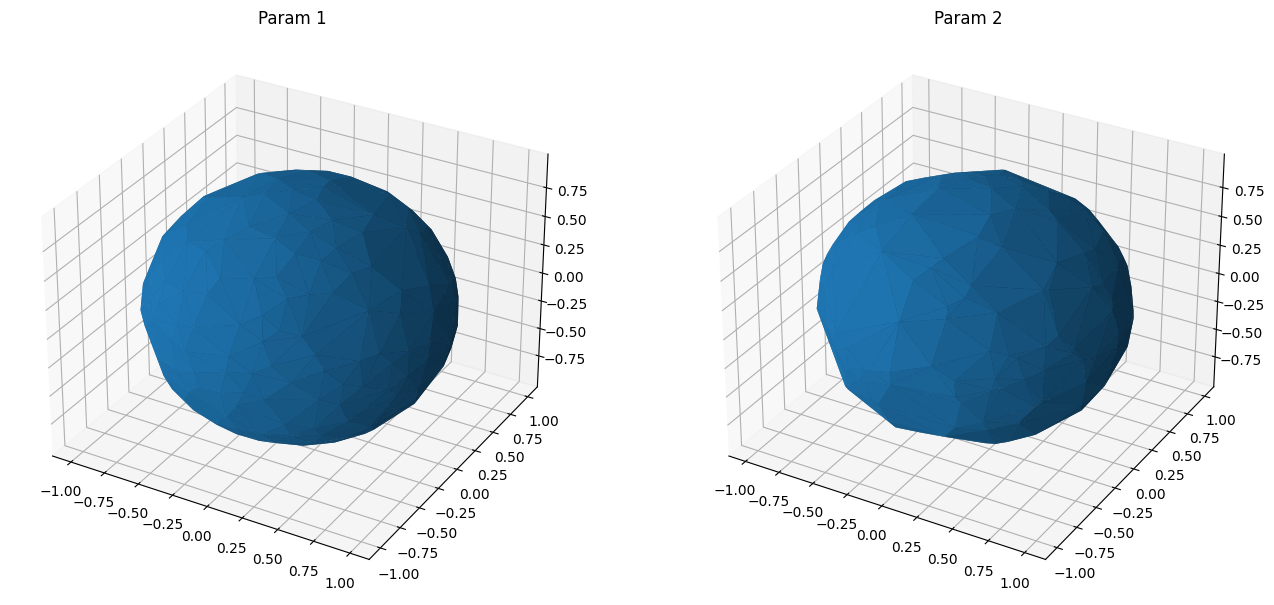

In [12]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Param 1")
ax2 = fig.add_subplot(122, projection='3d')
ax1.plot_trisurf(param.vertices[:, 0], param.vertices[:,1], triangles=param.faces, Z=param.vertices[:,2])
ax2.plot_trisurf(reparam.vertices[:, 0], reparam.vertices[:,1], triangles=reparam.faces, Z=reparam.vertices[:,2]) 
ax2.set_title("Param 2")
plt.show()

## Define distances

In [7]:
# torch type and device
use_cuda = torch.cuda.is_available()
torchdeviceId = torch.device("cuda:0") if use_cuda else "cpu"
#torchdeviceId = "cpu"
torchdtype = torch.float32

# PyKeOps counterpart
KeOpsdeviceId = torchdeviceId.index  # id of Gpu device (in case Gpu is  used)
KeOpsdtype = torchdtype.__str__().split(".")[1]  # 'float32'

def varifold_dist(mesh1, mesh2, sigma):
    
    V1, F1 = np.array(mesh1.vertices), np.array(mesh1.faces)
    V2, F2 = np.array(mesh2.vertices), np.array(mesh2.faces)
    
    q0 = torch.from_numpy(V1).clone().detach().to(dtype=torchdtype, device=torchdeviceId).requires_grad_(True)
    VT = torch.from_numpy(V2).clone().detach().to(dtype=torchdtype, device=torchdeviceId)
    FS = torch.from_numpy(F1).clone().detach().to(dtype=torch.long, device=torchdeviceId)
    FT = torch.from_numpy(F2).clone().detach().to(dtype=torch.long, device=torchdeviceId)
    sigma = torch.tensor([sigma], dtype=torchdtype, device=torchdeviceId)
    
    p0 = torch.zeros(q0.shape, dtype=torchdtype, device=torchdeviceId, requires_grad=True)
    dataloss = lddmm_utils.lossVarifoldSurf(FS, VT, FT, lddmm_utils.GaussLinKernel(sigma=sigma))
    Kv = lddmm_utils.GaussKernel(sigma=sigma)
    loss = lddmm_utils.LDDMMloss(Kv, dataloss)

    dist = loss(p0, q0)

    return(dist)

## Relative varifold distance of reparameterized ellipsoids

In [8]:
original = ["data/artificial_database/ref_base/" + str(i)+ ".ply" for i in range(999)]
reparam = ["data/artificial_database/reparam_base/" + str(i)+ ".ply" for i in range(999)]

In [9]:
varifold_dist(tri.load_mesh(original[0]), tri.load_mesh(reparam[0]), sigma = 1)

[KeOps] Generating code for formula Sum_Reduction((Exp(-((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))*Var(5,1,2))*Sum(Var(2,3,0)*Var(3,3,1))**2)*Var(4,1,1),0) ... OK
[KeOps] Generating code for formula Sum_Reduction(Exp(-((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))*Var(3,1,2))*Var(2,3,1),0) ... OK
[KeOps] Generating code for formula Sum_Reduction(-((2*(Var(3,1,2)*((Var(4,3,0)|Var(2,3,1))*Exp(-((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))*Var(3,1,2)))))*(Var(0,3,0)-Var(1,3,1))),0) ... OK
[KeOps] Generating code for formula Sum_Reduction(-((2*(Var(3,1,2)*((Var(4,3,0)|Var(2,3,1))*Exp(-((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))*Var(3,1,2)))))*-(Var(0,3,0)-Var(1,3,1))),1) ... OK
[KeOps] Generating code for formula Sum_Reduction(Exp(-((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)))*Var(3,1,2))*Var(4,3,0),1) ... OK


tensor(0.3980, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
relative_distance = []
for i in range(999):
    relative_distance.append(varifold_dist(tri.load_mesh(original[i]), tri.load_mesh(reparam[i]), sigma = 0.1))

### Test on 1 expression

In [ ]:
COMA1 = tri.load_mesh('data/bareteeth.000001_COMA_id1.ply')
COMA2 = tri.load_mesh('data/bareteeth.000001_COMA_id2.ply')

FLAME1 = tri.load_mesh('data/bareteeth.000001_FLAME_id1.ply')
FLAME2 = tri.load_mesh('data/bareteeth.000001_FLAME_id2.ply')

sigma = 0.6

In [ ]:
d2 = np.linalg.norm(np.array(COMA1.vertices) - np.array(COMA2.vertices))
print(d2)

In [ ]:
flame1 = ["data/FLAME_id1_expr1/" + path for path in listdir("data/FLAME_id1_expr1") if "ply" in path]
coma1 = ["data/COMA_id1_expr1/" + path for path in listdir("data/COMA_id1_expr1") if "ply" in path]
flame2 = ["data/FLAME_id2_expr1/" + path for path in listdir("data/FLAME_id2_expr1") if "ply" in path]
coma2 = ["data/COMA_id2_expr1/" + path for path in listdir("data/COMA_id2_expr1") if "ply" in path]
flame3 = ["data/FLAME_id3_expr1/" + path for path in listdir("data/FLAME_id3_expr1") if "ply" in path]
coma3 = ["data/COMA_id3_expr1/" + path for path in listdir("data/COMA_id3_expr1") if "ply" in path]

In [ ]:
sigmas = np.linspace(0.0001,0.2, 20)
sigma = 0.1

diff_coma = []
diff_coma_l2 = []
diff_flame = []
diff_flame_l2 = []
for sigma in sigmas:
    dist_var = []
    dist_l2 = []
    for i in range(np.min([len(coma1), len(coma2)])):
        mesh1, mesh2 = tri.load_mesh(coma1[i]), tri.load_mesh(coma2[i])
    
        dist_var.append(varifold_dist(mesh1,mesh2, sigma).item())
        dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))
    
    diff_coma.append(np.mean(dist_var))
    diff_coma_l2.append(np.mean(dist_l2))
diff_coma = np.array(diff_coma)
diff_coma_l2 = np.array(diff_coma_l2)

for sigma in sigmas:
    dist_var = []
    dist_l2 = []
    for i in range(np.min([len(coma1), len(flame2)])):
        mesh1, mesh2 = tri.load_mesh(coma1[i]), tri.load_mesh(flame2[i])
    
        dist_var.append(varifold_dist(mesh1,mesh2, sigma).item())
        dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))
    
    diff_flame.append(np.mean(dist_var))
    diff_flame_l2.append(np.mean(dist_l2))
diff_flame = np.array(diff_flame)
diff_flame_l2 = np.array(diff_flame_l2)

In [ ]:
Y = np.abs(diff_coma - diff_flame)/diff_coma * 100
Y2 = np.abs(diff_coma_l2 - diff_flame_l2)/diff_coma_l2 * 100

plt.plot(sigmas,Y, 'b', label='varifold metric')
plt.plot(sigmas,Y2, 'r', label ='$L^2$ metric')
plt.legend(loc = 'upper left') 

In [ ]:
dist_var = []
dist_l2 = []

for i in range(np.min([len(coma1), len(coma2)])):
    mesh1, mesh2 = tri.load_mesh(coma1[i]), tri.load_mesh(coma2[i])
    
    dist_var.append(varifold_dist(mesh1,mesh2,sigma).item())
    dist_l2.append(np.linalg.norm(np.array(mesh1.vertices) - np.array(mesh2.vertices)))